Step 1: Generate Synthetic Credit Data

In [1]:
import numpy as np
import pandas as pd

np.random.seed(42)
n_samples = 20000

data = pd.DataFrame({
    'age': np.random.randint(21, 75, n_samples),
    'income': np.random.normal(60000, 20000, n_samples).clip(10000, None),
    'loan_amount': np.random.normal(25000, 10000, n_samples).clip(5000, None),
    'loan_term_months': np.random.choice([12, 24, 36, 48, 60], n_samples),
    'credit_score': np.random.randint(300, 850, n_samples),
    'previous_defaults': np.random.poisson(0.3, n_samples),
    'employment_status': np.random.choice(['employed', 'unemployed', 'self-employed'], n_samples, p=[0.7, 0.1, 0.2]),
})

# Encode employment_status as numeric
data['employment_status_num'] = data['employment_status'].map({'employed': 0, 'self-employed': 1, 'unemployed': 2})

# Define a logit for default
logit = (
    -0.03 * data['age'] +
    -0.000015 * data['income'] +
    0.00006 * data['loan_amount'] +
    0.01 * data['loan_term_months'] +
    -0.004 * data['credit_score'] +
    0.8 * data['previous_defaults'] +
    0.4 * data['employment_status_num']
)

# Sigmoid function for PD
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

data['pd_true'] = sigmoid(logit)

# Simulate default flag
data['default'] = np.random.binomial(1, data['pd_true'])

# Clean data (drop temp numeric employment)
data.drop(columns=['employment_status_num'], inplace=True)

data.head()


,age,income,loan_amount,loan_term_months,credit_score,previous_defaults,employment_status,pd_true,default
0,59,52550.567552,22798.548130,12,464,0,employed,0.050866,0
1,72,95354.636247,32808.922380,36,435,1,self-employed,0.141634,0
2,49,10757.597781,17674.204722,60,551,0,employed,0.102026,0
3,35,20406.861844,36766.810109,60,436,1,self-employed,0.712162,1
4,63,46395.707555,37601.241688,12,743,0,employed,0.039854,0


Step 2: Feature Engineering

In [2]:
data['dti'] = data['loan_amount'] / data['income']  # Debt to Income Ratio

# Bin credit score into categories
bins = [300, 579, 669, 739, 799, 850]
labels = ['Poor', 'Fair', 'Good', 'Very Good', 'Excellent']
data['credit_score_bin'] = pd.cut(data['credit_score'], bins=bins, labels=labels, right=True)

# Flag for high loan amount
data['high_loan'] = (data['loan_amount'] > 40000).astype(int)

# Convert categorical to dummy variables
data = pd.get_dummies(data, columns=['employment_status', 'credit_score_bin'], drop_first=True)


In [8]:
data.head()

,age,income,loan_amount,loan_term_months,credit_score,previous_defaults,pd_true,default,dti,high_loan,employment_status_self-employed,employment_status_unemployed,credit_score_bin_Fair,credit_score_bin_Good,credit_score_bin_Very Good,credit_score_bin_Excellent
0,59,52550.567552,22798.548130,12,464,0,0.050866,0,0.433840,0,False,False,False,False,False,False
1,72,95354.636247,32808.922380,36,435,1,0.141634,0,0.344073,0,True,False,False,False,False,False
2,49,10757.597781,17674.204722,60,551,0,0.102026,0,1.642951,0,False,False,False,False,False,False
3,35,20406.861844,36766.810109,60,436,1,0.712162,1,1.801689,0,True,False,False,False,False,False
4,63,46395.707555,37601.241688,12,743,0,0.039854,0,0.810447,0,False,False,False,False,True,False


Step 3: Model Building

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix

# Define features and target
features = [col for col in data.columns if col not in ['default', 'pd_true']]
X = data[features]
y = data['default']

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Logistic Regression
logreg = LogisticRegression(max_iter=1000)
logreg.fit(X_train, y_train)

# Predictions
y_pred_prob_logreg = logreg.predict_proba(X_test)[:, 1]
y_pred_logreg = logreg.predict(X_test)

# Evaluate
print("Logistic Regression AUC:", roc_auc_score(y_test, y_pred_prob_logreg))
print(classification_report(y_test, y_pred_logreg))

# Random Forest
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

y_pred_prob_rf = rf.predict_proba(X_test)[:, 1]
y_pred_rf = rf.predict(X_test)

print("Random Forest AUC:", roc_auc_score(y_test, y_pred_prob_rf))
print(classification_report(y_test, y_pred_rf))


Logistic Regression AUC: 0.7917940983781356
              precision    recall  f1-score   support

           0       0.89      0.99      0.93      5258
           1       0.55      0.13      0.21       742

    accuracy                           0.88      6000
   macro avg       0.72      0.56      0.57      6000
weighted avg       0.85      0.88      0.85      6000

Random Forest AUC: 0.7415558015048818
              precision    recall  f1-score   support

           0       0.89      0.98      0.93      5258
           1       0.49      0.11      0.19       742

    accuracy                           0.88      6000
   macro avg       0.69      0.55      0.56      6000
weighted avg       0.84      0.88      0.84      6000



Step 4: Model Validation & Calibration

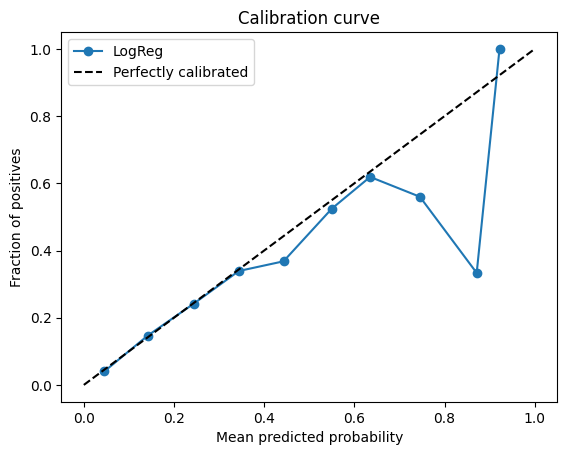

In [4]:
import matplotlib.pyplot as plt
from sklearn.calibration import calibration_curve

prob_true, prob_pred = calibration_curve(y_test, y_pred_prob_logreg, n_bins=10)

plt.plot(prob_pred, prob_true, marker='o', label='LogReg')
plt.plot([0,1],[0,1],'k--', label='Perfectly calibrated')
plt.xlabel('Mean predicted probability')
plt.ylabel('Fraction of positives')
plt.title('Calibration curve')
plt.legend()
plt.show()


/usr/local/lib/python3.11/dist-packages/sklearn/calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(


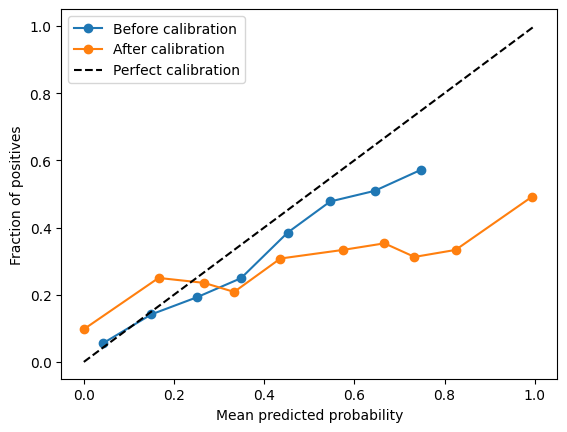

In [10]:
from sklearn.calibration import CalibratedClassifierCV, calibration_curve
import matplotlib.pyplot as plt

# Calibrate model using isotonic regression
calibrated_rf = CalibratedClassifierCV(rf, method='isotonic', cv='prefit')
calibrated_rf.fit(X_train, y_train)

# Plot before and after calibration
prob_pos_before = rf.predict_proba(X_test)[:, 1]
prob_pos_after = calibrated_rf.predict_proba(X_test)[:, 1]

prob_true_before, prob_pred_before = calibration_curve(y_test, prob_pos_before, n_bins=10)
prob_true_after, prob_pred_after = calibration_curve(y_test, prob_pos_after, n_bins=10)

plt.plot(prob_pred_before, prob_true_before, marker='o', label='Before calibration')
plt.plot(prob_pred_after, prob_true_after, marker='o', label='After calibration')
plt.plot([0,1],[0,1],'k--', label='Perfect calibration')
plt.xlabel('Mean predicted probability')
plt.ylabel('Fraction of positives')
plt.legend()
plt.show()


/usr/local/lib/python3.11/dist-packages/sklearn/calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(


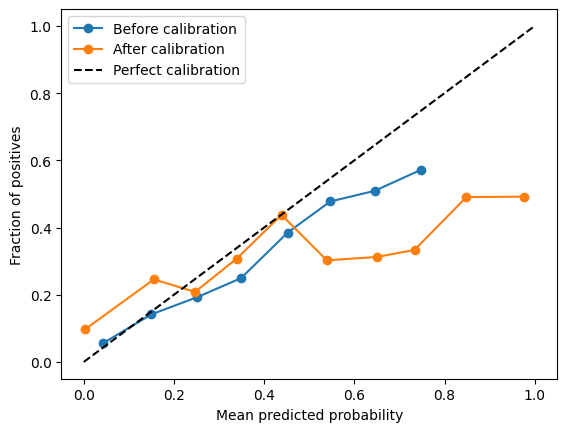

In [13]:
calibrated_rf = CalibratedClassifierCV(rf, method='sigmoid', cv='prefit')  # sigmoid = Platt scaling
calibrated_rf.fit(X_train, y_train)

# Plot before and after calibration
prob_pos_before = rf.predict_proba(X_test)[:, 1]
prob_pos_after = calibrated_rf.predict_proba(X_test)[:, 1]

prob_true_before, prob_pred_before = calibration_curve(y_test, prob_pos_before, n_bins=10)
prob_true_after, prob_pred_after = calibration_curve(y_test, prob_pos_after, n_bins=10)

plt.plot(prob_pred_before, prob_true_before, marker='o', label='Before calibration')
plt.plot(prob_pred_after, prob_true_after, marker='o', label='After calibration')
plt.plot([0,1],[0,1],'k--', label='Perfect calibration')
plt.xlabel('Mean predicted probability')
plt.ylabel('Fraction of positives')
plt.legend()
plt.show()

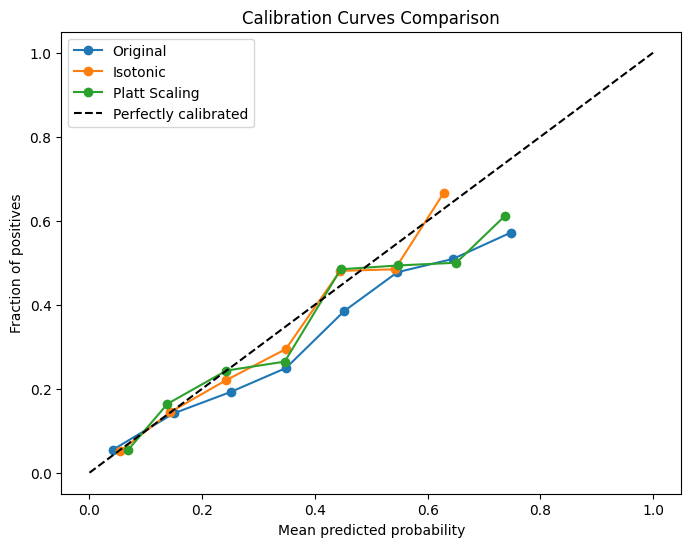

In [12]:
methods = {
    "Original": rf,
    "Isotonic": CalibratedClassifierCV(rf, method='isotonic', cv=5),
    "Platt Scaling": CalibratedClassifierCV(rf, method='sigmoid', cv=5)
}

plt.figure(figsize=(8, 6))

for name, model in methods.items():
    if name == "Original":
        prob_pos = rf.predict_proba(X_test)[:, 1]
    else:
        model.fit(X_train, y_train)
        prob_pos = model.predict_proba(X_test)[:, 1]
    prob_true, prob_pred = calibration_curve(y_test, prob_pos, n_bins=10)
    plt.plot(prob_pred, prob_true, marker='o', label=name)

plt.plot([0, 1], [0, 1], 'k--', label='Perfectly calibrated')
plt.xlabel('Mean predicted probability')
plt.ylabel('Fraction of positives')
plt.title('Calibration Curves Comparison')
plt.legend()
plt.show()


In [5]:
importances = rf.feature_importances_
feat_importance = pd.Series(importances, index=features).sort_values(ascending=False)
print(feat_importance.head(10))


credit_score                       0.182951
loan_amount                        0.176363
dti                                0.176297
income                             0.158694
age                                0.138946
loan_term_months                   0.059359
previous_defaults                  0.040160
employment_status_self-employed    0.018121
employment_status_unemployed       0.017651
credit_score_bin_Fair              0.007538
dtype: float64


Step 5: Model Robustness Checks

In [9]:
# Get pandas indices for subgroups
employed_idx = X_test[(X_test.get('employment_status_self-employed', 0) == 0) &
                      (X_test.get('employment_status_unemployed', 0) == 0)].index

self_emp_idx = X_test[X_test.get('employment_status_self-employed', 0) == 1].index
unemp_idx = X_test[X_test.get('employment_status_unemployed', 0) == 1].index

# Convert pandas indices to integer positions in the test set
employed_pos = X_test.index.get_indexer(employed_idx)
self_emp_pos = X_test.index.get_indexer(self_emp_idx)
unemp_pos = X_test.index.get_indexer(unemp_idx)

from sklearn.metrics import roc_auc_score

print(f"AUC for employed: {roc_auc_score(y_test.iloc[employed_pos], y_pred_prob_logreg[employed_pos]):.4f}")
print(f"AUC for self-employed: {roc_auc_score(y_test.iloc[self_emp_pos], y_pred_prob_logreg[self_emp_pos]):.4f}")
print(f"AUC for unemployed: {roc_auc_score(y_test.iloc[unemp_pos], y_pred_prob_logreg[unemp_pos]):.4f}")


AUC for employed: 0.7960
AUC for self-employed: 0.7626
AUC for unemployed: 0.8031
